In [1]:
import trimesh
import trimesh.transformations as TF
import torch
import numpy as np
import random

In [2]:
import Render
Render.extIOR, Render.intIOR = 1.15, 1.0
# Render.extIOR, Render.intIOR = 1.5, 1.0
res=512
Float = torch.float64
device='cuda'
Render.res = res
Render.device = device
Render.Float = Float

In [3]:
# kitten = Render.Scene("/root/workspace/data/kitten.obj")
kitten = Render.Scene("/root/workspace/data/kitten_vh_sim.ply")
kitten.set_camera((60,60), 1.1, center=(0,0,0), angles=None)
R,K = kitten.camera_RK()
origin, ray_dir = kitten.generate_ray()


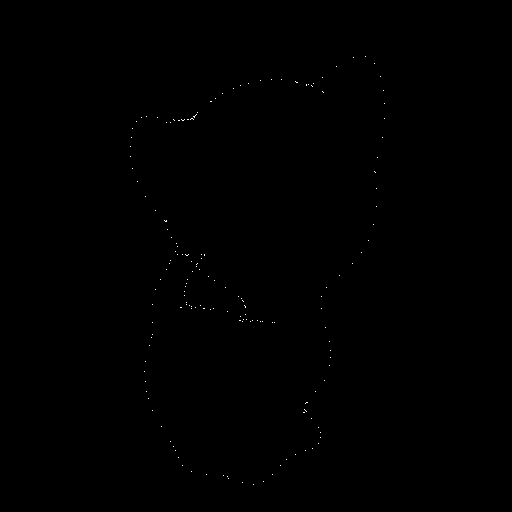

In [4]:
silhouette_edge = kitten.silhouette_edge(origin[0])
index, output = kitten.primary_visibility(silhouette_edge, R, K, origin[0])
image = torch.zeros((res,res))
image[index[:,0],index[:,1]]=1
Render.PILimage(image)

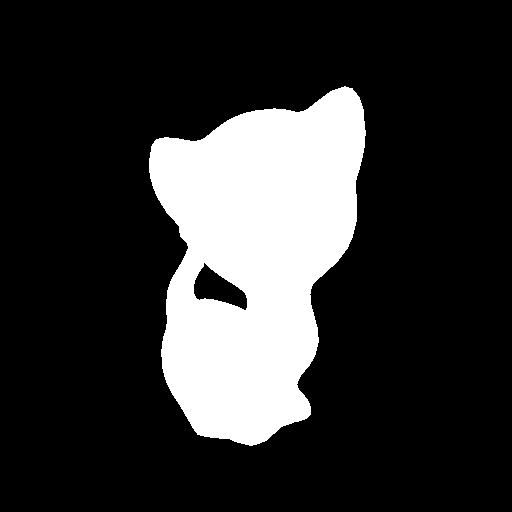

In [22]:
# kitten = Render.Scene("/root/workspace/data/kitten.obj")
kitten = Render.Scene("/root/workspace/data/kitten_vh_sim.ply")
kitten.set_camera((60,60), 1.3, center=(0,0,0), angles=None)
R,K = kitten.camera_RK()
origin, ray_dir = kitten.generate_ray()
target_mask = kitten.mask(origin, ray_dir)
Render.PILimage(target_mask)

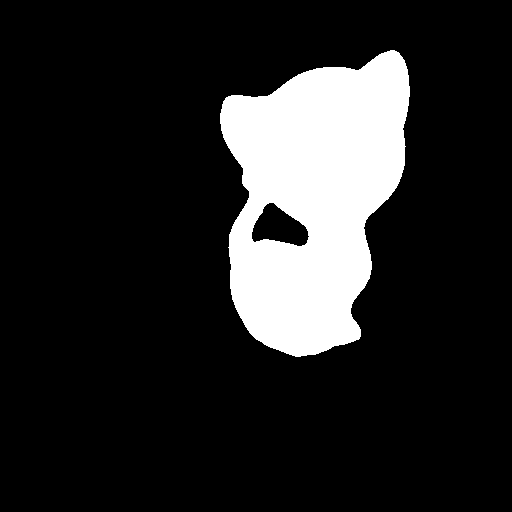

In [23]:
new_vert = kitten.vertices + torch.tensor([0.2,0.2,-0.2], device=device)
kitten.update_verticex(new_vert)
Render.PILimage(kitten.mask(origin, ray_dir))

In [24]:

vertices = kitten.vertices
parameter = torch.zeros(3,  device=device, requires_grad=True)
opt = torch.optim.Adam([parameter], lr=.02)
gif = []
for i in range(99):

    mask = kitten.mask(origin, ray_dir)
    gif.append(Render.PILimage(mask))
    error = (target_mask - mask).abs().mean()
    print('Iteration %03i: error=%g' % (i, error), end='\r')

    opt.zero_grad()
    new_vert = vertices + parameter
    kitten.update_verticex(new_vert)
    silhouette_edge = kitten.silhouette_edge(origin[0])
    index, output = kitten.primary_visibility(silhouette_edge, R, K, origin[0])
    loss = (target_mask.view((res,res))[index[:,0],index[:,1]] - output).abs().sum()
    loss.backward()
    opt.step()
()


Iteration 098: error=0.00915146

()

In [25]:
import imageio
imageio.mimsave('sil.gif',gif)

In [ ]:
def render_target(scene:Render.Scene, deg):
    #俯视
    M=TF.rotation_matrix(-np.pi/180*0, [1,0,0])
    angle = TF.euler_from_matrix(TF.rotation_matrix(np.pi/180*deg, [0,1,0]) @ M)
    # scene.set_camera(fov=(60,60), distance = 1.0, center=(0,0.0,0), angles=angle)
    scene.set_camera(fov=(60,60), distance = 1.1, center=(0,0.0,0), angles=angle)
    origin, ray_dir = scene.generate_ray()
    target, target_mask = scene.render_transparent(origin, ray_dir)
    return target, target_mask, origin, ray_dir

Target = Render.Scene("/root/workspace/data/kitten.obj")
Views = []
# for deg in [-30,-15,0,15,30]:
for deg in range(-90,90,45):
    Views.append(render_target(Target, deg))
# for deg in [-30,-15,0,15,30]:
for deg in range(-90,90,45):
    Views.append(render_target(Target, deg+180))



In [ ]:
Render.PILimage(Views[2][0])

In [ ]:
# mesh_vh = trimesh.load("/root/workspace/data/bunny.ply")
# mesh_vh = trimesh.load("/root/workspace/data/kitten.obj")
# mesh_vh = trimesh.load("/root/workspace/data/kitten_vh_sim.ply")
# mesh_vh = trimesh.load("/root/workspace/data/hand_vh_sim.ply")
# mesh_vh = trimesh.load("/root/workspace/data/hand_vh_sub.ply")
# mesh_vh = trimesh.load("/root/workspace/data/kitten_vh_sub.ply")
# mesh_vh.apply_transform(TF.rotation_matrix(-np.pi/2, [1,0,0]))
# mesh_vh.export("result/hand_init.ply")

kitten_vh = Render.Scene("/root/workspace/data/kitten_vh_sim.ply")
vh_vertices = kitten_vh.vertices
vh_normals = torch.tensor(kitten_vh.mesh.vertex_normals, dtype=Float, device=device)

# parameter = torch.zeros((vh_vertices.shape[0],1), requires_grad=True)
# parameter = torch.zeros(bunny_sm.vertices.shape, requires_grad=True)
# parameter = torch.zeros([len(vh_vertices),1], dtype=Float, requires_grad=True, device=device)
parameter = torch.zeros(vh_vertices.shape, dtype=Float, requires_grad=True, device=device)
parameter.register_hook(kitten_vh.laplac_hook)
opt = torch.optim.Adam([parameter], lr=.0002)
# opt = torch.optim.SGD([parameter], lr=.05)



In [ ]:

for it in range(99):
    V_index = random.randint(0, len(Views)-1)
    # V_index = 2
    target, target_mask, origin, ray_dir = Views[V_index]
    # Zero out gradients before each iteration
    opt.zero_grad()

    # vertices = vh_vertices + parameter * vh_normals
    vertices = vh_vertices + parameter
    kitten_vh.update_verticex(vertices)
    render_img, render_mask = kitten_vh.render_transparent(origin, ray_dir)
     
    mask = (target_mask * render_mask)
    loss = (render_img[mask]-target[mask]).pow(2).mean()
    kitten_vh.hook_w = 0.0
    # laplac = 0
    rough = 0.001*parameter.abs().mean()
    (loss+rough).backward()
    # loss.backward()

    # Optimizer: take a gradient step
    opt.step()

    # save_image("result/img_{}.png".format(it), render.detach().cpu())
    # print('Iteration %03i: error=%g laplac=%g' % (it, loss, laplac_hook.rough), end='\r')
    print('Iteration %03i: error=%g rough=%g hook=%g' % (it, loss, rough, kitten_vh.hook_rough), end='\r')
    # imageio.imsave("result/disp_{}.png".format(it), parameter.detach().cpu())
    

# imageio.imsave("displacment.png", parameter.detach().cpu())
# save_image("result/optim.png", render.detach())
# mesh_vh.export("result/hand_optim.ply")
# _=mesh_vh.export("hand_optim.ply")
# _=mesh_vh.export("kitten_optim.ply")


In [ ]:
Render.PILimage(render_img)

In [ ]:
mesh_vh = trimesh.load("/root/workspace/data/hand_vh_sim.ply")
vh_vertices = torch.tensor(mesh_vh.vertices, dtype=Float, device=device)
neighbors=mesh_vh.vertex_neighbors
col = np.concatenate(neighbors)
row = np.concatenate([[i] * len(n) for i, n in enumerate(neighbors)])
data = np.concatenate([[1.0 / len(n)] * len(n) for n in neighbors])
col = torch.tensor(col, device=device)
row = torch.tensor(row, device=device)
i = torch.stack((row,col))
data = torch.tensor(data, dtype=Float, device=device)
SM_size = torch.Size([len(vertices),len(vertices)])
weightM=torch.sparse.FloatTensor(i, data, SM_size)
iterations = 10
lamb = 0.5
for _index in range(iterations):
    # vol_ini = mesh_vh.volume
    laplac = vh_vertices - weightM.mm(vh_vertices)
    vh_vertices -= lamb * laplac
    mesh_vh.vertices = vh_vertices.detach().cpu().numpy()
    # vol_new = mesh_vh.volume
    # vh_vertices *= ((vol_ini / vol_new) ** (1.0 / 3.0))
mesh_vh.vertices = vh_vertices.detach().cpu().numpy()


In [ ]:
_=mesh_vh.export("hand_sm.ply")